# SOLUTION: Model Building, Scoring & Evaluating (XGBoost)

## Imports

In [1]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.types as T

from snowflake.ml.modeling.xgboost import XGBClassifier
from snowflake.ml.modeling.metrics import *

import json
import pandas as pd
import seaborn as sns

## Create Snowpark Session

In [2]:
with open('creds.json') as f:
    connection_parameters = json.load(f)

In [3]:
session = Session.builder.configs(connection_parameters).create()
print(f"Current Database and schema: {session.get_fully_qualified_current_schema()}")
print(f"Current Warehouse: {session.get_current_warehouse()}")

Current Database and schema: "HOL_DB"."PUBLIC"
Current Warehouse: "HOL_WH"


# Model Building

In [4]:
train_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TRAIN')
test_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TEST')

# SOLUTION: Train an XGBoost Model

In [5]:
feature_cols = train_sdf.columns
feature_cols.remove('TARGET')
feature_cols.remove('ID')
target_col = 'TARGET'

xgbmodel = XGBClassifier(
    random_state=123, 
    input_cols=feature_cols, 
    label_cols=target_col, 
    output_cols='PREDICTION'
    )
xgbmodel.fit(train_sdf)

The fitted model can be retrieved as an XGB object

In [6]:
xgbmodel_local = xgbmodel.to_xgboost()

<Axes: >

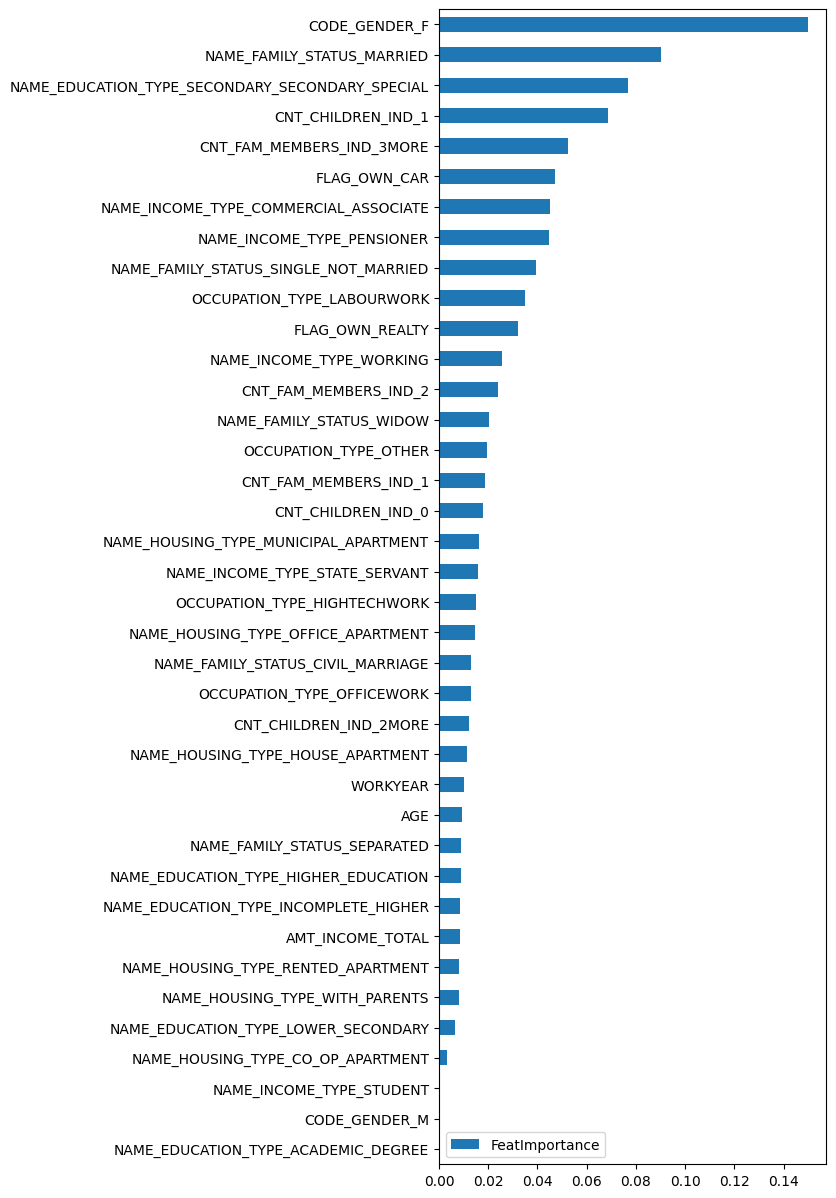

In [7]:
# Plot feature importance
feat_importance = pd.DataFrame(xgbmodel_local.feature_importances_,xgbmodel_local.feature_names_in_,columns=['FeatImportance'])
feat_importance.sort_values('FeatImportance').plot.barh(y='FeatImportance', figsize=(5,15))

# Model Scoring

# SOLUTION: Use the fitted XGBoost Model to score a Snowpark DataFrame

In [8]:
scored_sdf = xgbmodel.predict(test_sdf)
scored_sdf.write.save_as_table(table_name='CREDIT_RISK_PREPARED_BALANCED_TEST_SCORED', mode='overwrite')
session.table('CREDIT_RISK_PREPARED_BALANCED_TEST_SCORED').show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Model Evaluation

# Solution: Evaluate model performance

Acccuracy: 0.989606
Precision: 0.9875285803367283


DataFrame.flatten() is deprecated since 0.7.0. Use `DataFrame.join_table_function()` instead.


Recall: 0.9889675270607827
F1: 0.9882475299011961


<Axes: >

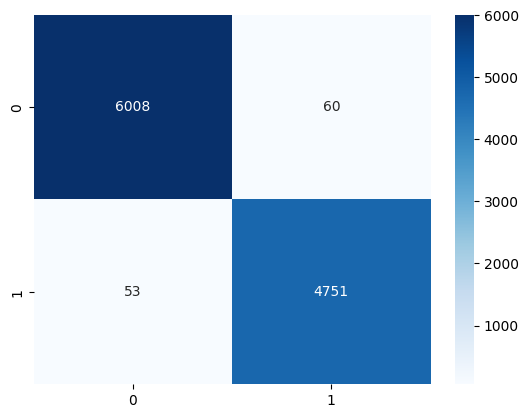

In [9]:
print('Acccuracy:', accuracy_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='PREDICTION'))
print('Precision:', precision_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='PREDICTION'))
print('Recall:', recall_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='PREDICTION'))
print('F1:', f1_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='PREDICTION'))

# Obtaining and plotting a simple confusion matrix
cf_matrix = confusion_matrix(df=scored_sdf, y_true_col_name='TARGET', y_pred_col_name='PREDICTION')

sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

In [10]:
session.close()